In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image

import warnings
warnings.simplefilter('ignore')

import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, GlobalAvgPool2D, AvgPool2D, MaxPool2D
from tensorflow.keras.layers import Flatten, Dense, Softmax, DepthwiseConv2D, BatchNormalization, ReLU
from tensorflow.keras.applications import Xception
from tensorflow.keras.preprocessing import image
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import load_model

In [3]:
df_train = pd.read_csv("../input/gtsrb-german-traffic-sign/Train.csv")
df_test = pd.read_csv("../input/gtsrb-german-traffic-sign/Test.csv")

Train_path = "../input/gtsrb-german-traffic-sign/Train"
Test_path = "../input/gtsrb-german-traffic-sign/Train"

In [4]:
df_train.head()

,Width,Height,Roi.X1,Roi.Y1,Roi.X2,Roi.Y2,ClassId,Path
0,27,26,5,5,22,20,20,Train/20/00020_00000_00000.png
1,28,27,5,6,23,22,20,Train/20/00020_00000_00001.png
2,29,26,6,5,24,21,20,Train/20/00020_00000_00002.png
3,28,27,5,6,23,22,20,Train/20/00020_00000_00003.png
4,28,26,5,5,23,21,20,Train/20/00020_00000_00004.png


In [5]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39209 entries, 0 to 39208
Data columns (total 8 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   Width    39209 non-null  int64 
 1   Height   39209 non-null  int64 
 2   Roi.X1   39209 non-null  int64 
 3   Roi.Y1   39209 non-null  int64 
 4   Roi.X2   39209 non-null  int64 
 5   Roi.Y2   39209 non-null  int64 
 6   ClassId  39209 non-null  int64 
 7   Path     39209 non-null  object
dtypes: int64(7), object(1)
memory usage: 2.4+ MB


## Ploting some Images

In [6]:
df_img = df_train.sample(frac=1)
df_img = df_img.head()
df_img

,Width,Height,Roi.X1,Roi.Y1,Roi.X2,Roi.Y2,ClassId,Path
4122,39,38,6,5,34,33,2,Train/2/00002_00044_00012.png
31632,46,37,6,5,41,32,30,Train/30/00030_00000_00012.png
13968,50,51,5,5,45,46,9,Train/9/00009_00013_00018.png
22866,35,40,5,5,30,35,14,Train/14/00014_00008_00006.png
3028,74,71,7,6,68,65,2,Train/2/00002_00007_00028.png


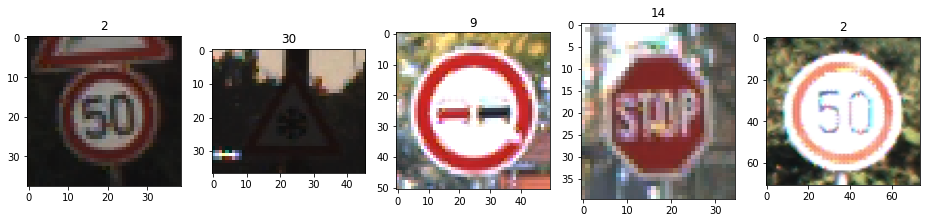

In [7]:
plt.figure(figsize=(16,9))
for i in range(5):
    plt.subplot(2,5,i+1)
    img = plt.imread("../input/gtsrb-german-traffic-sign/"+df_img.iloc[i][7])
    plt.title(df_img.iloc[i][6])
    plt.imshow(img)

In [8]:
Total_classes = len(os.listdir(Train_path))
print("Total Traffic Signs: ",Total_classes)

Total Traffic Signs:  43


In [9]:
for i in os.listdir(Train_path):
    length = len(os.listdir(Train_path +'/'+ str(i)))
    print("Total No of Images in label {} are {} Images".format(i,length))

Total No of Images in label 7 are 1440 Images
Total No of Images in label 17 are 1110 Images
Total No of Images in label 19 are 210 Images
Total No of Images in label 22 are 390 Images
Total No of Images in label 2 are 2250 Images
Total No of Images in label 35 are 1200 Images
Total No of Images in label 23 are 510 Images
Total No of Images in label 10 are 2010 Images
Total No of Images in label 5 are 1860 Images
Total No of Images in label 36 are 390 Images
Total No of Images in label 20 are 360 Images
Total No of Images in label 27 are 240 Images
Total No of Images in label 41 are 240 Images
Total No of Images in label 39 are 300 Images
Total No of Images in label 32 are 240 Images
Total No of Images in label 25 are 1500 Images
Total No of Images in label 42 are 240 Images
Total No of Images in label 8 are 1410 Images
Total No of Images in label 38 are 2070 Images
Total No of Images in label 12 are 2100 Images
Total No of Images in label 0 are 210 Images
Total No of Images in label 3

In [10]:
df_train['ClassId'] = df_train['ClassId'].astype(str)
for i in range(0, len(df_train['ClassId'])):
    if len(df_train['ClassId'][i]) == 1:
        df_train['ClassId'][i] = '0' + df_train['ClassId'][i]

In [11]:
df_test['ClassId'] = df_test['ClassId'].astype(str)
for i in range(0, len(df_test['ClassId'])):
    if len(df_test['ClassId'][i]) == 1:
        df_test['ClassId'][i] = '0' + df_test['ClassId'][i]

In [12]:
train_gen = image.ImageDataGenerator(rescale=1./255,
                               vertical_flip=True,
                               width_shift_range=0.2,
                               height_shift_range=0.2,
                               zoom_range=0.2)

testDataGen = image.ImageDataGenerator(rescale=1./255)

trainDataGenerator = train_gen.flow_from_dataframe(dataframe=df_train,
                                                   directory="../input/gtsrb-german-traffic-sign",
                                                   x_col='Path',
                                                   y_col='ClassId',
                                                   target_size=(299, 299),
                                                   batch_size=32,
                                                   class_mode='categorical')

testDataGenerator = testDataGen.flow_from_dataframe(dataframe=df_test,
                                                    directory='../input/gtsrb-german-traffic-sign/',
                                                    x_col='Path',
                                                    y_col='ClassId',
                                                    target_size=(299, 299),
                                                    batch_size=16,
                                                    class_mode='categorical')

Found 39209 validated image filenames belonging to 43 classes.
Found 12630 validated image filenames belonging to 43 classes.


In [13]:
xception = Xception(include_top=False, weights=None, input_shape=(299, 299, 3), pooling='avg')
model = Sequential([
                    xception,
                    Dense(43,activation='softmax')
])

model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])

In [14]:
history = model.fit(trainDataGenerator, epochs=5, verbose=1)

Epoch 1/5
1226/1226 [==============================] - 1334s 1s/step - loss: 2.4427 - accuracy: 0.3108
Epoch 2/5
1226/1226 [==============================] - 1181s 963ms/step - loss: 0.1578 - accuracy: 0.9524
Epoch 3/5
1226/1226 [==============================] - 1155s 942ms/step - loss: 0.0671 - accuracy: 0.9782
Epoch 4/5
1226/1226 [==============================] - 1162s 948ms/step - loss: 0.0569 - accuracy: 0.9832
Epoch 5/5
1226/1226 [==============================] - 1164s 949ms/step - loss: 0.0372 - accuracy: 0.9892


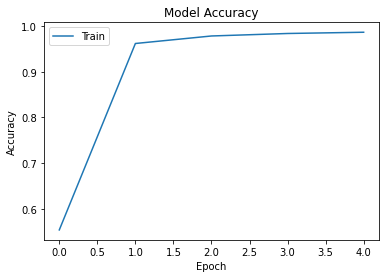

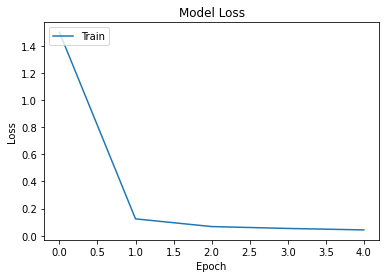

In [15]:
#Training
plt.plot(history.history['accuracy'])
plt.title("Model Accuracy")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.legend(['Train','Test'],loc='upper left')
plt.show()
#Loss
plt.plot(history.history['loss'])
plt.title("Model Loss")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.legend(['Train','Test'],loc='upper left')
plt.show()

# Model Saving

In [16]:
model.save("./saved_model/")

In [17]:
model.save("Traffic_sign.h5")
loaded_model = load_model('Traffic_sign.h5', compile = False)

## Quantization

### Without quantization


In [18]:
converter = tf.lite.TFLiteConverter.from_saved_model("./saved_model")
tflite_model = converter.convert()

In [19]:
len(tflite_model)

83513216

### with quantization


In [20]:
converter = tf.lite.TFLiteConverter.from_saved_model("./saved_model")
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_quant_model = converter.convert()

In [21]:
len(tflite_quant_model)

22005728

In [22]:
with open("tflite_model.tflite", "wb") as f:
    f.write(tflite_model)

In [23]:
with open("tflite_quant_model.tflite", "wb") as f:
    f.write(tflite_quant_model)

## Evaluating Model

In [24]:
model.evaluate(testDataGenerator, verbose=1)

790/790 [==============================] - 93s 116ms/step - loss: 0.1537 - accuracy: 0.9641


[0.15374988317489624, 0.9641330242156982]

## Testing Model

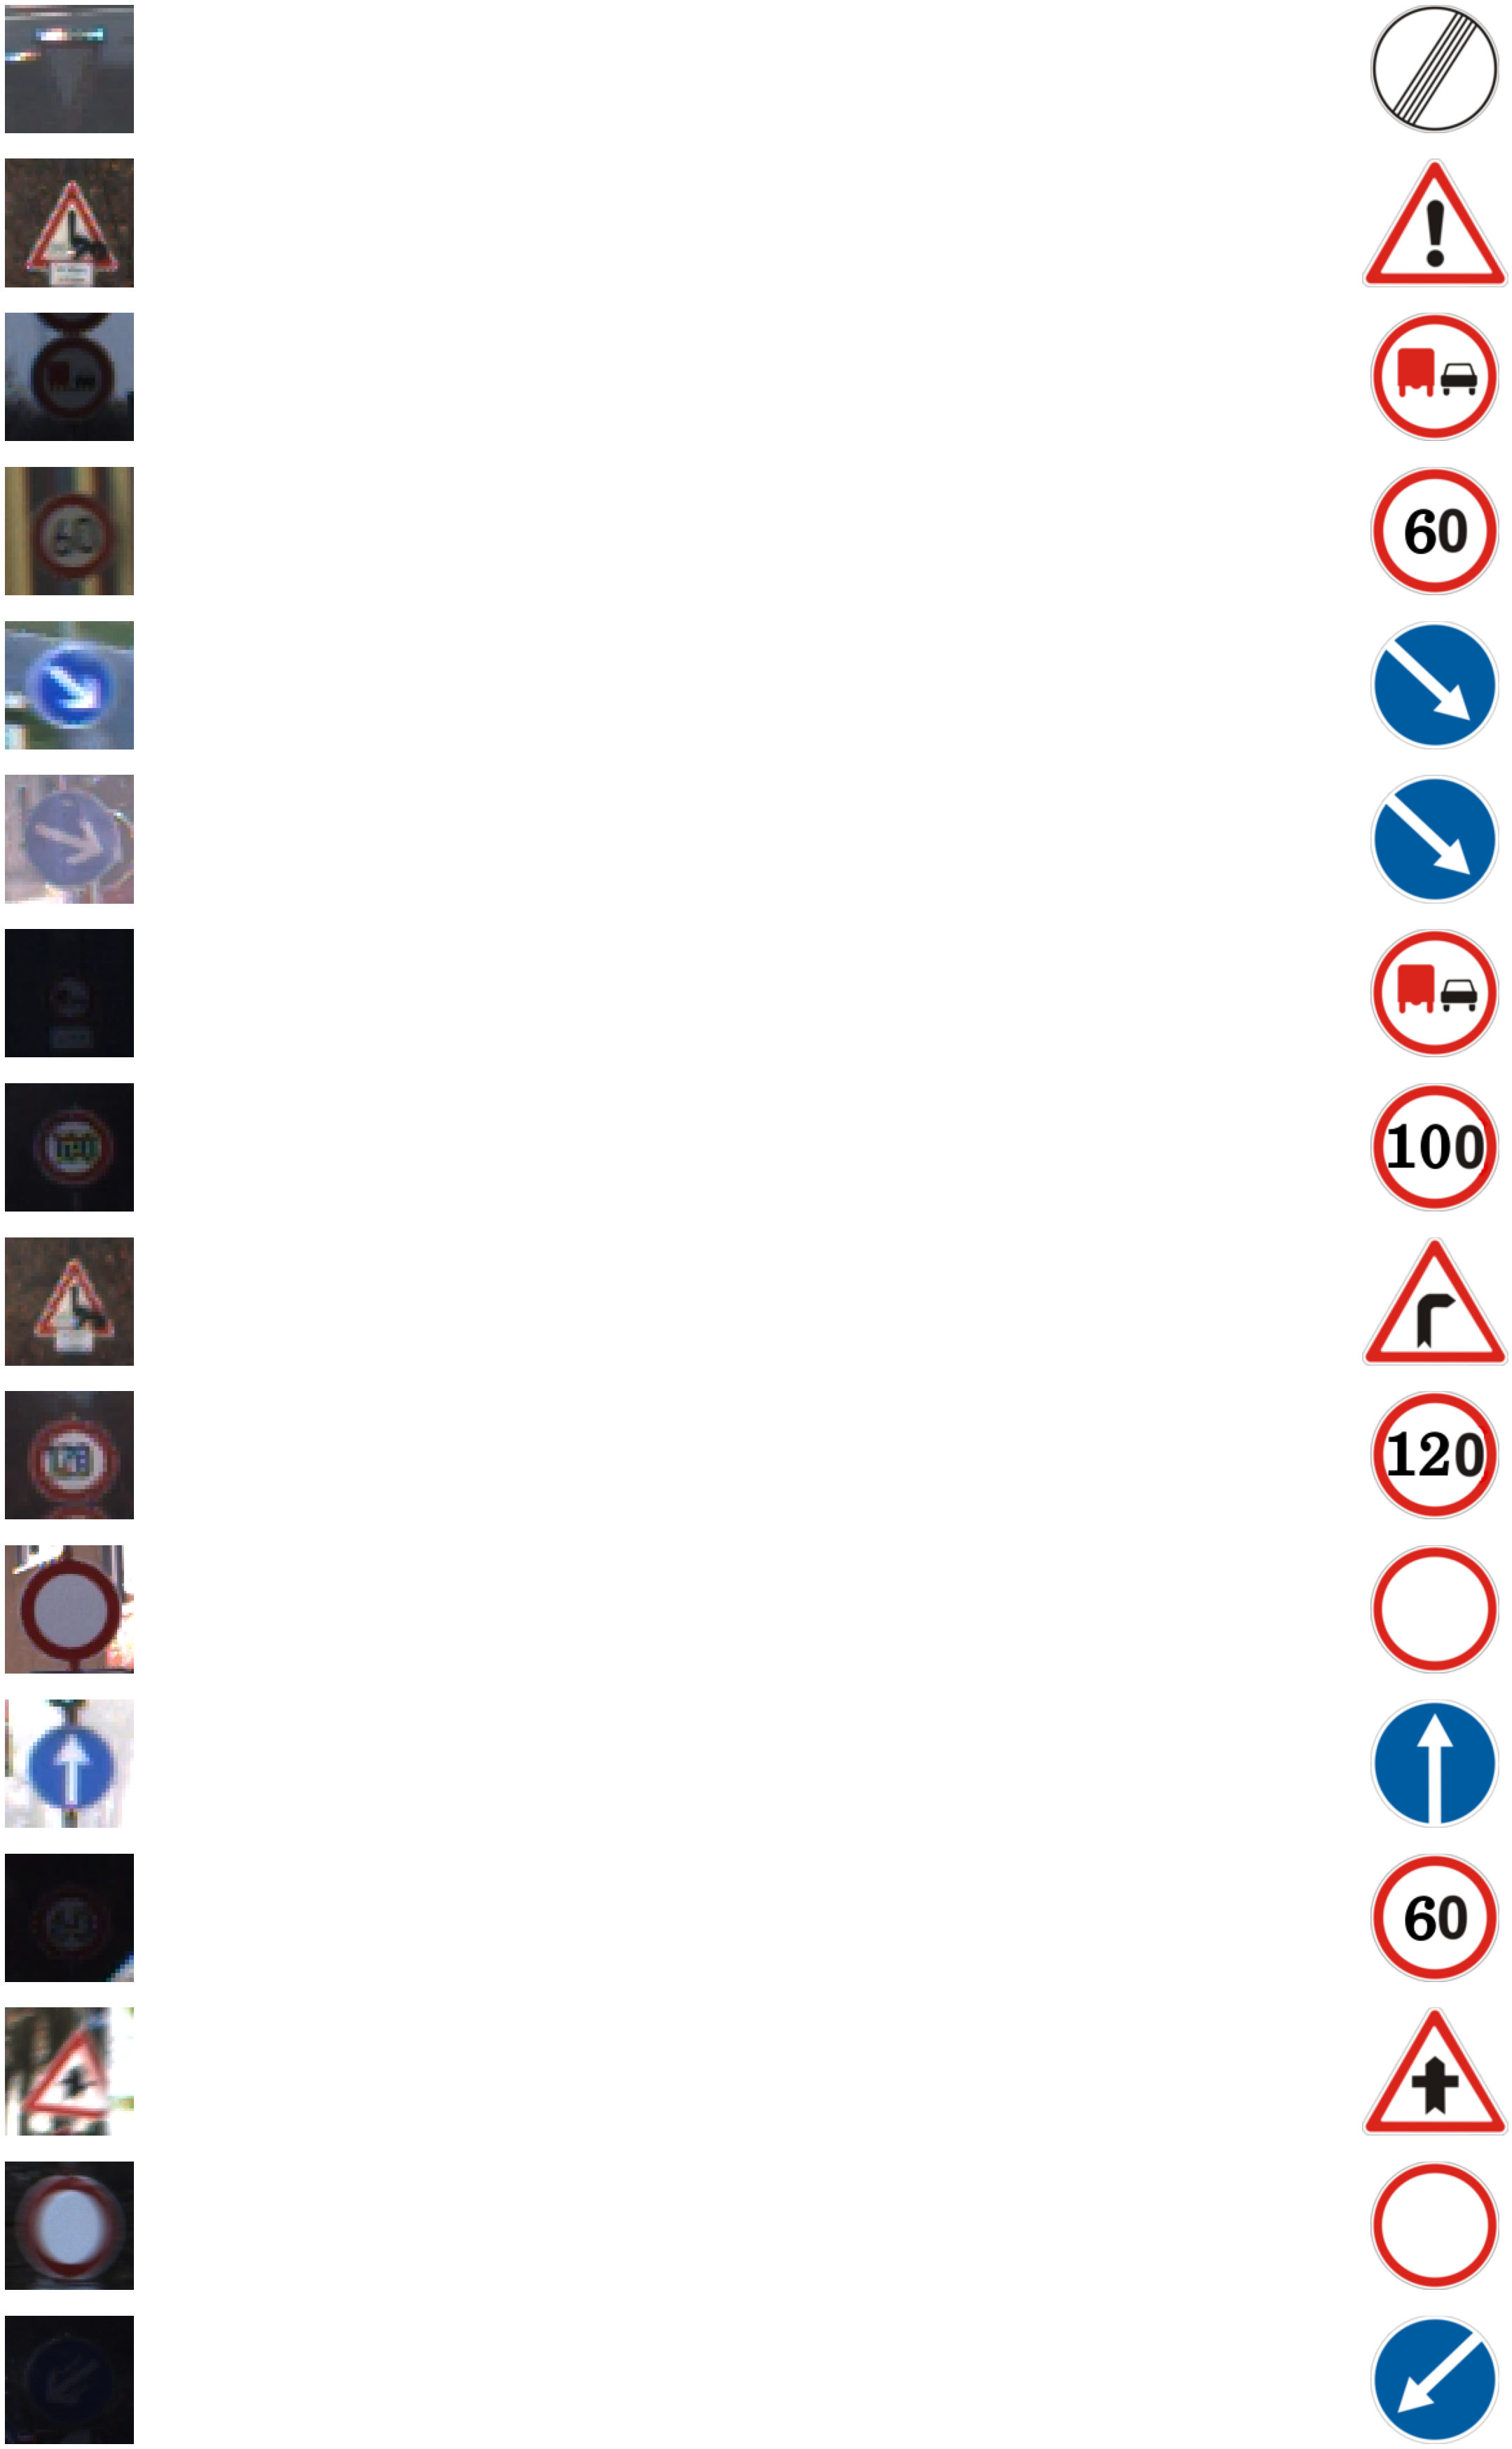

In [25]:
test_batch = 2
plt.figure(figsize=(64, 64))
plt.tight_layout()
for i in range(0, 16):
    plt.subplot(16, 2, 2 * i + 1), plt.axis('off')
    plt.imshow(testDataGenerator[test_batch][0][i])
    pre = model.predict_classes(testDataGenerator[test_batch][0])
    img = Image.open('../input/gtsrb-german-traffic-sign/Meta/' + str(pre[i]) + '.png')
    plt.subplot(16, 2, 2 * i + 2), plt.axis('off')
    plt.imshow(img)